# Fine-Tuning CamemBERT : Classification avec Comparaison de Learning Rates

## Objectifs de ce notebook

Dans ce notebook, nous allons :
- Entraîner un modèle CamemBERT en mode Fine-Tuning avec **3 learning rates différents**
- Comparer les performances des 3 modèles
- Sauvegarder le meilleur modèle pour la production

## 1. Imports et Configuration

In [1]:
# Configuration pour Keras 3 avec Transformers (DOIT être avant les imports)
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import json

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Sklearn pour métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n TensorFlow version: {tf.__version__}")
try:
    print(f" Keras version: {keras.__version__}")
except AttributeError:
    print(f" Keras version: tf-keras (legacy)")
print(f" Backend: {keras.backend.backend()}")
print(f" TF_USE_LEGACY_KERAS: {os.environ.get('TF_USE_LEGACY_KERAS', 'Not set')}")
print(f" Keras module: {keras.__name__}")

2025-12-07 15:25:30.754004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 GPU(s) détecté(s): 1 - Croissance mémoire activée

 TensorFlow version: 2.20.0
 Keras version: tf-keras (legacy)
 Backend: tensorflow
 TF_USE_LEGACY_KERAS: 1
 Keras module: tf_keras.api._v2.keras


#### Chargement du dataset et traitement des cellules manquantes

In [2]:
# Télécharger le dataset csv et l'afficher
print(" Chargement du dataset CSV...\n")

# Charger le CSV
df = pd.read_csv('data/dataset-for-training-completed.csv')

print(f" Dataset chargé : {len(df)} lignes")
print(f"\nColonnes : {list(df.columns)}")
print(f"\n Aperçu des données :")
print(df.head())

# Nettoyer les données : supprimer les lignes avec des valeurs manquantes
print(f"\n Nettoyage des données...")
print(f"Lignes avec valeurs manquantes : {df.isnull().sum().sum()}")
df = df.dropna()

# Nettoyer les thématiques : supprimer les lignes avec thématiques vides ou invalides
df['Thématique'] = df['Thématique'].str.strip()  # Supprimer espaces
df = df[df['Thématique'].str.len() > 0]  # Supprimer thématiques vides
df = df[~df['Thématique'].str.match(r'^[\W_]+$')]  # Supprimer thématiques avec seulement des caractères spéciaux

print(f" Après nettoyage : {len(df)} lignes")

# Statistiques des thématiques
print(f"\n Distribution des thématiques :")
thematic_counts = df['Thématique'].value_counts()
print(thematic_counts)
print(f"\nNombre de thématiques uniques : {df['Thématique'].nunique()}")

 Chargement du dataset CSV...

 Dataset chargé : 5102 lignes

Colonnes : ['Titres opération et projet lauréat', 'Thématique']

 Aperçu des données :
                  Titres opération et projet lauréat             Thématique
0  Du street art quartier des impressionnistes Ar...           Cadre de vie
1  Des bancs pour les écoles du boulevard Pereire...  Education et jeunesse
2  Des lanternes pour le quartier historique du 2...           Cadre de vie
3  Aménager et équiper la cour de l'école de l'av...  Education et jeunesse
4  Installer des espaces de convivialité a Buttes...           Cadre de vie

 Nettoyage des données...
Lignes avec valeurs manquantes : 0
 Après nettoyage : 5102 lignes

 Distribution des thématiques :
Thématique
Education et jeunesse     1404
Environnement              968
Cadre de vie               758
Solidarités                590
Culture et patrimoine      340
Sport                      334
Propreté                   308
Attractivité et emploi     141
Mobilités 

#### Nettoyage du corpus texte (colonne "Thématique")

In [3]:
# Nettoyage du texte français
def preprocess_text(text):
    """Normalisation du texte français"""
    text = text.lower()
    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüÿœ'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(" Nettoyage des titres de projets...\n")
# AVANT 
print(df['Titres opération et projet lauréat'].head(20))
# Appliquer le preprocessing sur la colonne "Titres opération et projet lauréat"
df['Titres opération et projet lauréat'] = df['Titres opération et projet lauréat'].apply(preprocess_text)

# APRES
print(" Titres nettoyés !")
print(f"\n Exemples de titres nettoyés :")
print(df['Titres opération et projet lauréat'].head(20))

 Nettoyage des titres de projets...

0     Du street art quartier des impressionnistes Ar...
1     Des bancs pour les écoles du boulevard Pereire...
2     Des lanternes pour le quartier historique du 2...
3     Aménager et équiper la cour de l'école de l'av...
4     Installer des espaces de convivialité a Buttes...
5     Développer le réseau cyclable dans le 19e Cont...
6     Piétonnisation du quartier Saint-Séverin Piéto...
7     Rénovation de la sous-dalle Beaugrenelle Rénov...
8     Remise en état de l'horloge de l'église Saint-...
9     Des améliorations rue Jeanne d'Arc Rénover les...
10    Cultiver au Champ-de-Mars Cultiver au Champ de...
11    Les Petits Maraîchers - potagers pédagogiques ...
12    Pont Broca street art - Les Contes de la rue B...
13    Un terrain de basket aux Halles Playground du ...
14    Parcours végétal et artistique entre Montmartr...
15    Aménagements dans les écoles du quartier Epine...
16    Végétaliser les trottoirs du 15e Végétaliser l...
17    Rénov

#### Encodage des labels et sauvegarde de la clé de traduction

In [ ]:
# Encoder les thématiques (string) en entiers AVANT la séparation
print(" Encodage des thématiques en entiers...\n")

# Créer l'encodeur
label_encoder = LabelEncoder()

# Fit sur TOUTES les thématiques du dataset
label_encoder.fit(df['Thématique'])

# Transformer toutes les thématiques
y_all_encoded = label_encoder.transform(df['Thématique'])

# Nombre de classes
num_classes = len(label_encoder.classes_)

print(f" Encodage terminé !")
print(f"\n Nombre de classes : {num_classes}")
print(f"\n  Mapping des thématiques (10 premières) :")
for idx, thematic in enumerate(label_encoder.classes_[:10]):
    print(f"   {idx} → {thematic}")

if num_classes > 10:
    print(f"   ... et {num_classes - 10} autres thématiques")

# Sauvegarder l'encodeur et le mapping pour la production
print(f"\n Sauvegarde du mapping...")

# Créer le mapping num → label et label → num
mapping_dict = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
reverse_mapping = {str(label): int(i) for i, label in enumerate(label_encoder.classes_)}

# Sauvegarder en JSON (human-readable)
with open('model/label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({
        'num_to_label': mapping_dict,
        'label_to_num': reverse_mapping,
        'num_classes': num_classes
    }, f, ensure_ascii=False, indent=2)

print(f" Fichiers sauvegardés :")
print(f"   - model/label_mapping.json")
print(f"\n Exemple :")
print(f"   Thématique originale : '{df['Thématique'].iloc[0]}'")
print(f"   Thématique encodée   : {y_all_encoded[0]}")


 Encodage des thématiques en entiers...

 Encodage terminé !

 Nombre de classes : 11

  Mapping des thématiques (10 premières) :
   0 → Attractivité et emploi
   1 → Cadre de vie
   2 → Culture et patrimoine
   3 → Education et jeunesse
   4 → Environnement
   5 → Mobilités
   6 → Propreté
   7 → Prévention et sécurité
   8 → Santé
   9 → Solidarités
   ... et 1 autres thématiques

 Sauvegarde de l'encodeur et du mapping...
 Fichiers sauvegardés :
   - model/label_mapping.json

 Exemple :
   Thématique originale : 'Cadre de vie'
   Thématique encodée   : 1


#### Séparation des jeux de test/train/validation

In [5]:
print(f" Séparation des données...\n")

# Extraire X (textes) et y (thématiques ENCODÉES)
X_all = df['Titres opération et projet lauréat'].values
y_all = y_all_encoded  # Utiliser les labels encodés

print(f"Nombre total de projets : {len(X_all)}")
print(f"Nombre de thématiques uniques : {num_classes}")

# Séparation 70% train / 30% test (stratifié pour garder la distribution des thématiques)
X_train_all_text, X_test_text, y_train_all, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=SEED, stratify=y_all
)

# Créer un validation set (20% du train)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_all_text, y_train_all, test_size=0.2, random_state=SEED, stratify=y_train_all
)

print(f"\n Préparation terminée !")
print(f"\n Répartition finale:")
print(f"   Train: {len(X_train_text):,} projets ({len(X_train_text)/len(df)*100:.1f}%)")
print(f"   Validation: {len(X_val_text):,} projets ({len(X_val_text)/len(df)*100:.1f}%)")
print(f"   Test: {len(X_test_text):,} projets ({len(X_test_text)/len(df)*100:.1f}%)")

print(f"\n Exemple de projet :")
print(f"Titre : {X_train_text[0]}")
print(f"Thématique (encodée) : {y_train[0]}")
print(f"Thématique (décodée) : {label_encoder.inverse_transform([y_train[0]])[0]}")

# Statistiques de longueur (convertir en str pour éviter les erreurs)
train_lengths = [len(str(text).split()) for text in X_train_text]
print(f"\n Longueur moyenne des titres: {np.mean(train_lengths):.1f} mots")
print(f" Longueur min: {np.min(train_lengths)} mots")
print(f" Longueur max: {np.max(train_lengths)} mots")

 Séparation des données...

Nombre total de projets : 5102
Nombre de thématiques uniques : 11

 Préparation terminée !

 Répartition finale:
   Train: 2,856 projets (56.0%)
   Validation: 715 projets (14.0%)
   Test: 1,531 projets (30.0%)

 Exemple de projet :
Titre : villerefuge casiers solidaires
Thématique (encodée) : 9
Thématique (décodée) : Solidarités

 Longueur moyenne des titres: 13.7 mots
 Longueur min: 1 mots
 Longueur max: 51 mots


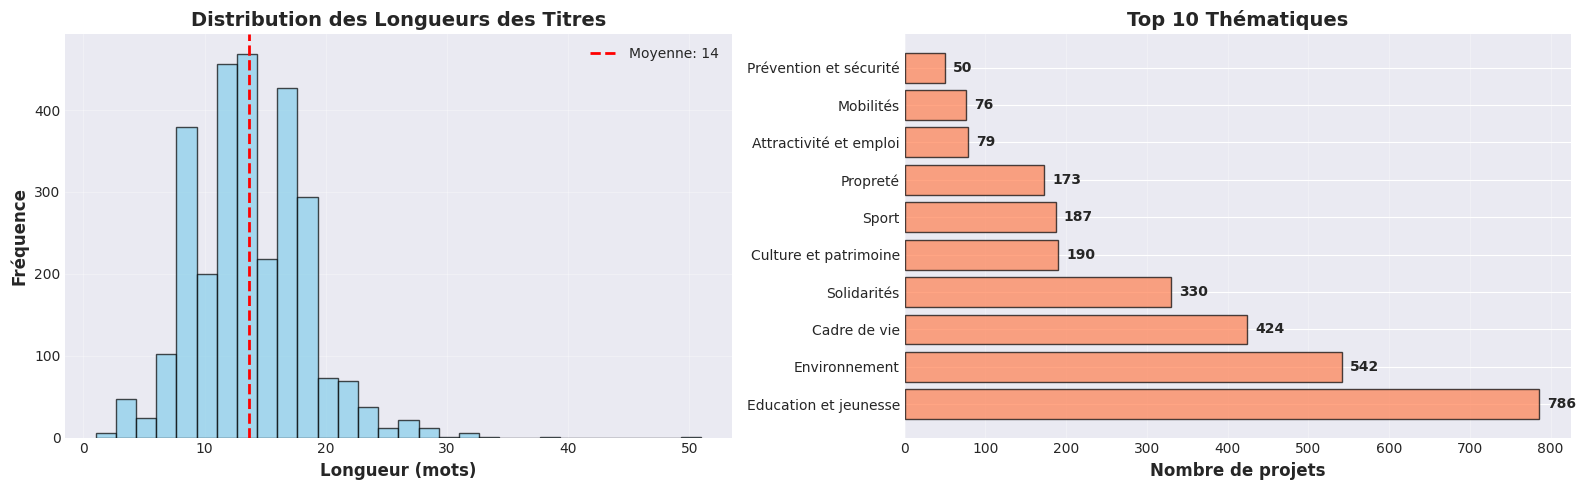


 Total de thématiques uniques: 11
 Thématique la plus fréquente: 'Education et jeunesse' (786 projets)


In [7]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Distribution des longueurs
ax1.hist(train_lengths, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs des Titres', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
thematic_counts = pd.Series(y_train_decoded).value_counts()
top_thematics = thematic_counts.head(10)  # Top 10 thématiques

ax2.barh(range(len(top_thematics)), top_thematics.values, color='coral', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(top_thematics)))
ax2.set_yticklabels(top_thematics.index, fontsize=10)
ax2.set_xlabel('Nombre de projets', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Thématiques', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, count in enumerate(top_thematics.values):
    ax2.text(count + 10, i, f'{count}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Total de thématiques uniques: {len(thematic_counts)}")
print(f" Thématique la plus fréquente: '{top_thematics.index[0]}' ({top_thematics.values[0]} projets)")

### 2.1 Exemples de Projets

In [8]:
# Afficher des exemples de différentes thématiques
print("\n" + "=" * 80)
print(" " * 25 + " EXEMPLES DE PROJETS")
print("=" * 80)

# Prendre des exemples de différentes thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
unique_thematics = pd.Series(y_train_decoded).unique()[:11]  # 10 premières thématiques

for thematic in unique_thematics:
    indices = np.where(y_train_decoded == thematic)[0][:3]  # 3 exemples par thématique
    
    print(f"\n  Thématique: {thematic}")
    print("-" * 80)
    
    for idx in indices:
        titre = X_train_text[idx]
        print(f"  • {titre} ({len(titre.split())} mots)")
    
    print(f"  → Total: {len(np.where(y_train_decoded == thematic)[0])} projets dans cette thématique")


                          EXEMPLES DE PROJETS

  Thématique: Solidarités
--------------------------------------------------------------------------------
  • villerefuge casiers solidaires (3 mots)
  • tousrécup outillage a travers fil (5 mots)
  • faire vivre la solidarité dans le e financer lachat dune voiture pour lassociation maat paris (15 mots)
  → Total: 330 projets dans cette thématique

  Thématique: Environnement
--------------------------------------------------------------------------------
  • de nature en ville de nature en ville ruchers appel à projets parc andré citroën (15 mots)
  • de nature en ville cultiver dans la crèche duméril (9 mots)
  • de nature en ville de nature en ville supports végétalisés pour chaque mairie darrdt (14 mots)
  → Total: 542 projets dans cette thématique

  Thématique: Education et jeunesse
--------------------------------------------------------------------------------
  • des tables de tri des déchets dans les cantines scolaires des tabl

## 3. CamemBERT avec HuggingFace

**CamemBERT** est un modèle BERT spécifiquement entraîné sur du français :
-  Pré-entraîné sur 138 Go de texte français (OSCAR)
-  Architecture BERT optimisée pour le français
-  Meilleure performance que BERT multilingue sur du texte français
-  Disponible via HuggingFace Transformers

### 3.2 Installation et Imports

In [9]:
# Imports pour HuggingFace Transformers et CamemBERT
from transformers import CamembertTokenizer, TFCamembertModel

print(" Transformers importé avec succès !")
print(f" CamembertTokenizer et TFCamembertModel disponibles")
print(f" Configuration : TF_USE_LEGACY_KERAS = {os.environ.get('TF_USE_LEGACY_KERAS', 'Not set')}")

 Transformers importé avec succès !
 CamembertTokenizer et TFCamembertModel disponibles
 Configuration : TF_USE_LEGACY_KERAS = 1


### 3.3 Préparation des Données pour CamemBERT

In [10]:
# Charger le tokenizer CamemBERT
print(" Chargement du tokenizer CamemBERT...\n")

try:
    # Utiliser le tokenizer CamemBERT pré-entraîné (base français)
    tokenizer_camembert = CamembertTokenizer.from_pretrained("camembert-base")
    
    print(" Tokenizer CamemBERT chargé !")
    print(f"Vocabulaire: {tokenizer_camembert.vocab_size:,} tokens")
    print(f"Longueur de séquence max: 128")
    
    # Test du tokenizer
    test_text = "création d'un espace vert dans le quartier"
    test_tokens = tokenizer_camembert(test_text, padding='max_length', truncation=True, max_length=128)
    
    print(f"\n Test du tokenizer:")
    print(f"Texte original: '{test_text}'")
    print(f"Tokens (premiers 20): {test_tokens['input_ids'][:20]}")
    print(f"Attention mask (premiers 20): {test_tokens['attention_mask'][:20]}")
    
except Exception as e:
    print(f" Erreur lors du chargement du tokenizer: {e}")
    raise

 Chargement du tokenizer CamemBERT...

 Tokenizer CamemBERT chargé !
Vocabulaire: 32,000 tokens
Longueur de séquence max: 128

 Test du tokenizer:
Texte original: 'création d'un espace vert dans le quartier'
Tokens (premiers 20): [5, 708, 18, 11, 59, 1326, 1798, 29, 16, 1449, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Attention mask (premiers 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Fonction pour tokenizer nos données
def tokenize_data(texts, max_length=128):
    """Tokenize les textes avec CamemBERT"""
    return tokenizer_camembert(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf' 
    )

# Tokenizer les données
print(" Tokenization des données avec CamemBERT...\n")

X_train_camembert = tokenize_data(X_train_text)
X_val_camembert = tokenize_data(X_val_text)
X_test_camembert = tokenize_data(X_test_text)

print(" Tokenization terminée !")
print(f"\n Shapes:")
print(f"   Train input_ids: {X_train_camembert['input_ids'].shape}")
print(f"   Val input_ids: {X_val_camembert['input_ids'].shape}")
print(f"   Test input_ids: {X_test_camembert['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


 Tokenization des données avec CamemBERT...



I0000 00:00:1765121142.601496    9207 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


 Tokenization terminée !

 Shapes:
   Train input_ids: (2856, 128)
   Val input_ids: (715, 128)
   Test input_ids: (1531, 128)


## 3. Fine-Tuning CamemBERT avec 3 Learning Rates

Nous allons entraîner le modèle CamemBERT avec 3 learning rates différents :
- **LR 1 : 1e-5** (conservateur)
- **LR 2 : 3e-5** (recommandé pour BERT)
- **LR 3 : 5e-5** (agressif)

In [12]:
def creer_modele_camembert_finetuned():
    """
    Crée un modèle CamemBERT avec fine-tuning complet.
    """
    print(" Chargement du modèle CamemBERT pour fine-tuning...\n")
    
    # Essai 1 : CamemBERT base officiel avec from_pt=True
    try:
        print("Tentative 1: Chargement de 'camembert-base' (from PyTorch)...")
        from transformers import TFCamembertModel
        camembert_backbone = TFCamembertModel.from_pretrained(
            "camembert-base",
            from_pt=True  # Charger depuis PyTorch pour éviter les erreurs safetensors
        )
        camembert_backbone.trainable = True  # FINE-TUNING
        print(" Modèle CamemBERT (camembert-base) chargé avec succès!")
        
    except Exception as e:
        print(f"  Erreur avec camembert-base: {type(e).__name__}")
        
        # Essai 2 : CamemBERT alternatif
        try:
            print("\nTentative 2: Chargement de 'almanach/camembert-base'...")
            camembert_backbone = TFCamembertModel.from_pretrained(
                "almanach/camembert-base",
                from_pt=True
            )
            camembert_backbone.trainable = True
            print(" Modèle CamemBERT (almanach) chargé avec succès!")
        except Exception as e2:
            print(f" Impossible de charger CamemBERT: {type(e2).__name__}")
            raise RuntimeError(f"Fine-tuning CamemBERT échoué: {type(e2).__name__}") from e2
    
    # Inputs
    input_ids = layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # CamemBERT
    camembert_output = camembert_backbone(input_ids, attention_mask=attention_mask)
    cls_token = camembert_output.last_hidden_state[:, 0, :]
    
    # Classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [13]:
# Learning rates à tester
learning_rates = [1e-5, 3e-5, 5e-5]
lr_names = ['LR_1e-5', 'LR_3e-5', 'LR_5e-5']

# Dictionnaires pour stocker les modèles et historiques
models_dict = {}
histories_dict = {}

print(" Entraînement de 3 modèles CamemBERT avec différents Learning Rates\n")
print("=" * 80)

 Entraînement de 3 modèles CamemBERT avec différents Learning Rates



In [14]:
# Boucle d'entraînement pour les 3 learning rates
for lr, lr_name in zip(learning_rates, lr_names):
    print(f"\n{'='*80}")
    print(f" Entraînement du modèle : {lr_name} (Learning Rate = {lr})")
    print(f"{'='*80}\n")
    
    # Créer le modèle
    model = creer_modele_camembert_finetuned()
    
    # Compiler avec le learning rate spécifique
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n Modèle {lr_name} créé et compilé !")
    print(f" Learning Rate: {lr}")
    print(f" Nombre total de paramètres entraînables: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
    
    # Entraînement
    print(f"\n Début de l'entraînement {lr_name}...\n")
    
    history = model.fit(
        [X_train_camembert['input_ids'], X_train_camembert['attention_mask']],
        y_train,
        validation_data=(
            [X_val_camembert['input_ids'], X_val_camembert['attention_mask']],
            y_val
        ),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Stocker le modèle et l'historique
    models_dict[lr_name] = model
    histories_dict[lr_name] = history
    
    print(f"\n Entraînement {lr_name} terminé !")
    print(f"   Meilleure val_accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"   Meilleure val_loss: {min(history.history['val_loss']):.4f}")

print("\n" + "=" * 80)
print(" Tous les entraînements sont terminés !")
print("=" * 80)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



 Entraînement du modèle : LR_1e-5 (Learning Rate = 1e-05)

 Chargement du modèle CamemBERT pour fine-tuning...

Tentative 1: Chargement de 'camembert-base' (from PyTorch)...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


 Modèle CamemBERT (camembert-base) chargé avec succès!

 Modèle LR_1e-5 créé et compilé !
 Learning Rate: 1e-05
 Nombre total de paramètres entraînables: 110,671,883

 Début de l'entraînement LR_1e-5...

Epoch 1/10


2025-12-07 15:26:18.784510: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f78c42b82d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 15:26:18.784539: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-07 15:26:18.841401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 15:26:18.916682: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765121179.097532   14340 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 [==============================] - 127s 909ms/step - loss: 2.1364 - accuracy: 0.3057 - val_loss: 1.6439 - val_accuracy: 0.5734 - lr: 1.0000e-05
Epoch 2/10
90/90 [==============================] - 80s 891ms/step - loss: 1.4686 - accuracy: 0.6075 - val_loss: 1.0420 - val_accuracy: 0.7273 - lr: 1.0000e-05
Epoch 3/10
90/90 [==============================] - 80s 886ms/step - loss: 1.0425 - accuracy: 0.7553 - val_loss: 0.7508 - val_accuracy: 0.8322 - lr: 1.0000e-05
Epoch 4/10
90/90 [==============================] - 80s 885ms/step - loss: 0.7734 - accuracy: 0.8361 - val_loss: 0.5692 - val_accuracy: 0.8853 - lr: 1.0000e-05
Epoch 5/10
90/90 [==============================] - 79s 882ms/step - loss: 0.5913 - accuracy: 0.8988 - val_loss: 0.4474 - val_accuracy: 0.9119 - lr: 1.0000e-05
Epoch 6/10
90/90 [==============================] - 80s 886ms/step - loss: 0.4787 - accuracy: 0.9212 - val_loss: 0.3994 - val_accuracy: 0.9161 - lr: 1.0000e-05
Epoch 7/10
90/90 [==============================] 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


 Modèle CamemBERT (camembert-base) chargé avec succès!

 Modèle LR_3e-5 créé et compilé !
 Learning Rate: 3e-05
 Nombre total de paramètres entraînables: 110,671,883

 Début de l'entraînement LR_3e-5...

Epoch 1/10
90/90 [==============================] - 129s 958ms/step - loss: 1.7001 - accuracy: 0.5203 - val_loss: 0.9004 - val_accuracy: 0.8140 - lr: 3.0000e-05
Epoch 2/10
90/90 [==============================] - 80s 894ms/step - loss: 0.8242 - accuracy: 0.8428 - val_loss: 0.5240 - val_accuracy: 0.8895 - lr: 3.0000e-05
Epoch 3/10
90/90 [==============================] - 80s 887ms/step - loss: 0.5355 - accuracy: 0.9069 - val_loss: 0.3881 - val_accuracy: 0.9133 - lr: 3.0000e-05
Epoch 4/10
90/90 [==============================] - 80s 887ms/step - loss: 0.3770 - accuracy: 0.9419 - val_loss: 0.3374 - val_accuracy: 0.9259 - lr: 3.0000e-05
Epoch 5/10
90/90 [==============================] - 79s 884ms/step - loss: 0.2846 - accuracy: 0.9573 - val_loss: 0.3323 - val_accuracy: 0.9189 - lr: 3.0000

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


 Modèle CamemBERT (camembert-base) chargé avec succès!

 Modèle LR_5e-5 créé et compilé !
 Learning Rate: 5e-05
 Nombre total de paramètres entraînables: 110,671,883

 Début de l'entraînement LR_5e-5...

Epoch 1/10
90/90 [==============================] - 128s 955ms/step - loss: 1.4699 - accuracy: 0.6019 - val_loss: 0.6271 - val_accuracy: 0.8685 - lr: 5.0000e-05
Epoch 2/10
90/90 [==============================] - 80s 892ms/step - loss: 0.5792 - accuracy: 0.8873 - val_loss: 0.3853 - val_accuracy: 0.9077 - lr: 5.0000e-05
Epoch 3/10
90/90 [==============================] - 80s 887ms/step - loss: 0.3612 - accuracy: 0.9321 - val_loss: 0.3040 - val_accuracy: 0.9273 - lr: 5.0000e-05
Epoch 4/10
90/90 [==============================] - 80s 886ms/step - loss: 0.2427 - accuracy: 0.9611 - val_loss: 0.2946 - val_accuracy: 0.9301 - lr: 5.0000e-05
Epoch 5/10
90/90 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9748
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999

## 4. Évaluation et Comparaison des 3 Modèles

In [15]:
# Évaluer les 3 modèles sur le test set
print("\n" + "=" * 80)
print(" " * 20 + " ÉVALUATION DES 3 MODÈLES SUR LE TEST SET")
print("=" * 80)

results_list = []
predictions_dict = {}

for lr_name in lr_names:
    model = models_dict[lr_name]
    
    print(f"\n Évaluation {lr_name}...")
    
    # Évaluation
    test_loss, test_acc = model.evaluate(
        [X_test_camembert['input_ids'], X_test_camembert['attention_mask']],
        y_test,
        verbose=0
    )
    
    # Prédictions
    y_pred_proba = model.predict(
        [X_test_camembert['input_ids'], X_test_camembert['attention_mask']],
        verbose=0
    )
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Stocker les prédictions
    predictions_dict[lr_name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Ajouter aux résultats
    results_list.append({
        'Modèle': lr_name,
        'Learning Rate': learning_rates[lr_names.index(lr_name)],
        'Test Loss': test_loss,
        'Test Accuracy': test_acc,
        'Best Val Acc': max(histories_dict[lr_name].history['val_accuracy'])
    })
    
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Créer le DataFrame de résultats
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n" + "=" * 80)
print("\n TABLEAU COMPARATIF DES PERFORMANCES\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)

# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Modèle']
best_accuracy = results_df.iloc[0]['Test Accuracy']
best_lr = results_df.iloc[0]['Learning Rate']

print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   Learning Rate: {best_lr}")
print(f"   Test Accuracy: {best_accuracy*100:.2f}%")
print(f"   Test Loss: {results_df.iloc[0]['Test Loss']:.4f}")

print("\n" + "=" * 80)


                     ÉVALUATION DES 3 MODÈLES SUR LE TEST SET

 Évaluation LR_1e-5...
   Test Loss: 0.3621
   Test Accuracy: 0.9092 (90.92%)

 Évaluation LR_3e-5...
   Test Loss: 0.3129
   Test Accuracy: 0.9197 (91.97%)

 Évaluation LR_5e-5...
   Test Loss: 0.3316
   Test Accuracy: 0.9216 (92.16%)


 TABLEAU COMPARATIF DES PERFORMANCES

 Modèle  Learning Rate  Test Loss  Test Accuracy  Best Val Acc
LR_5e-5        0.00005   0.331608        0.92162      0.930070
LR_3e-5        0.00003   0.312942        0.91966      0.925874
LR_1e-5        0.00001   0.362149        0.90921      0.930070


 MEILLEUR MODÈLE: LR_5e-5
   Learning Rate: 5e-05
   Test Accuracy: 92.16%
   Test Loss: 0.3316



In [16]:
# Classification reports détaillés pour chaque modèle
print("\n CLASSIFICATION REPORTS DÉTAILLÉS\n")
print("=" * 80)

for lr_name in lr_names:
    y_pred = predictions_dict[lr_name]['y_pred']
    
    print(f"\n{lr_name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("-" * 80)


 CLASSIFICATION REPORTS DÉTAILLÉS


LR_1e-5:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

Attractivité et emploi       0.93      1.00      0.97        42
          Cadre de vie       0.80      0.84      0.82       228
 Culture et patrimoine       0.85      0.86      0.86       102
 Education et jeunesse       0.96      0.98      0.97       421
         Environnement       0.92      0.93      0.93       291
             Mobilités       0.88      0.73      0.80        41
              Propreté       0.97      0.92      0.94        92
Prévention et sécurité       0.76      0.73      0.75        26
                 Santé       1.00      0.55      0.71        11
           Solidarités       0.92      0.88      0.90       177
                 Sport       0.93      0.94      0.94       100

              accuracy                           0.91      1531
             macro avg       0.90      

## 5. Visualisations Comparatives

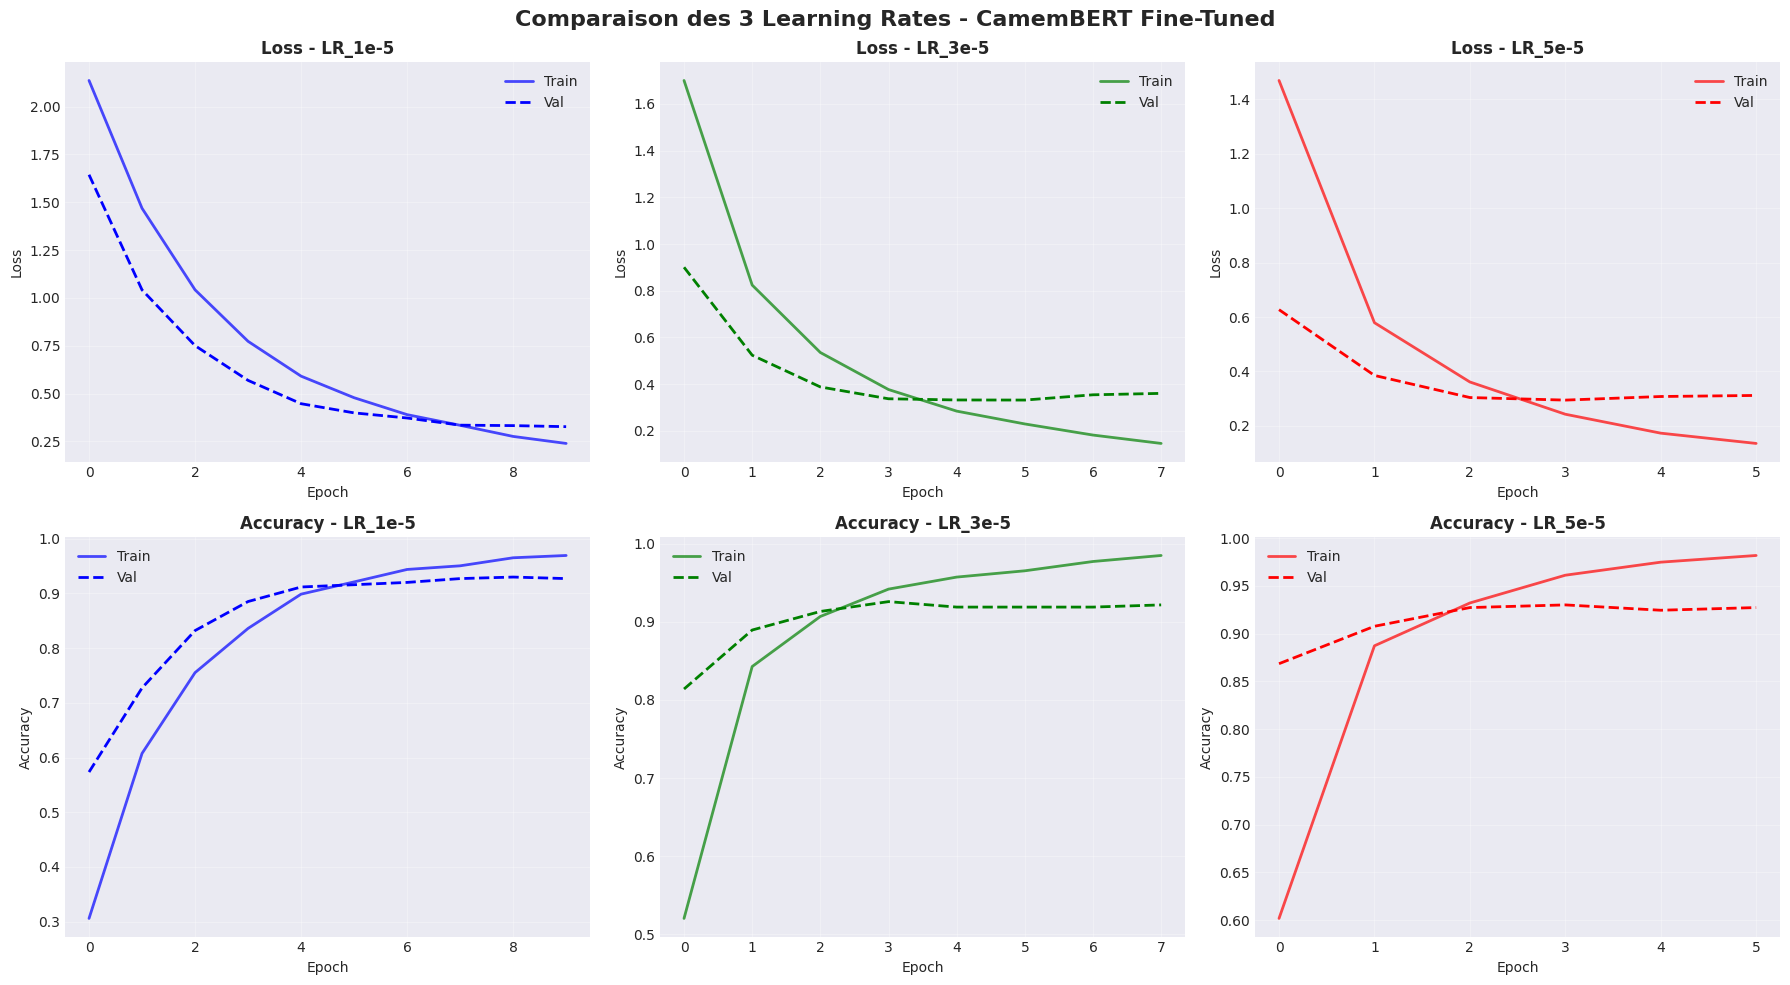

In [17]:
# Visualisation comparative des 3 modèles
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des 3 Learning Rates - CamemBERT Fine-Tuned', fontsize=16, fontweight='bold')

colors = ['blue', 'green', 'red']

# Loss
for idx, (lr_name, color) in enumerate(zip(lr_names, colors)):
    history = histories_dict[lr_name]
    ax = axes[0, idx]
    ax.plot(history.history['loss'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Loss - {lr_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

# Accuracy
for idx, (lr_name, color) in enumerate(zip(lr_names, colors)):
    history = histories_dict[lr_name]
    ax = axes[1, idx]
    ax.plot(history.history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Accuracy - {lr_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1 Graphique Comparatif des Accuracies

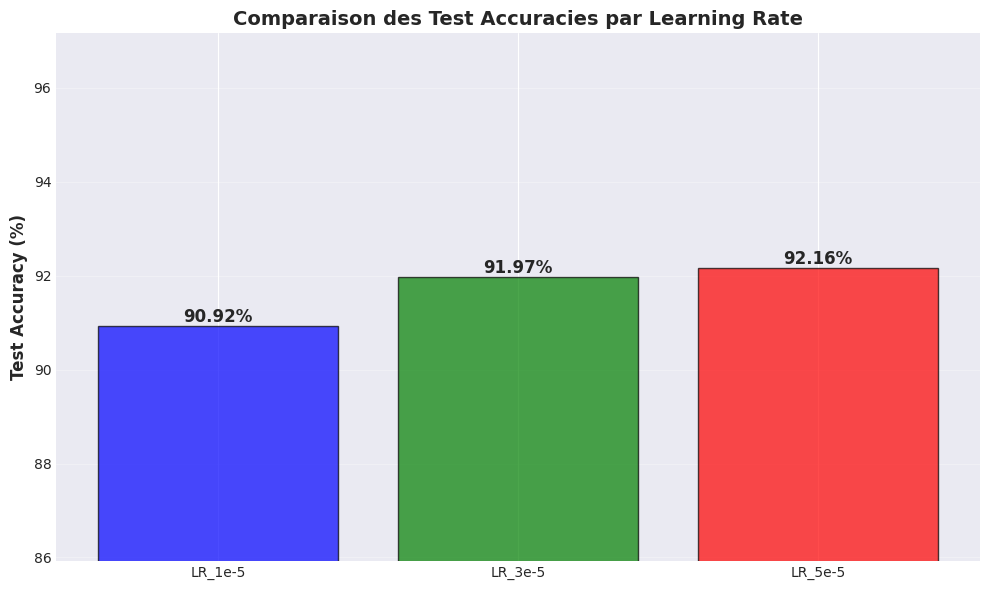


 Écart de performance:
   Meilleur: 92.16%
   Moins bon: 90.92%
   Différence: 1.24%


In [18]:
# Graphique à barres comparant les test accuracies
fig, ax = plt.subplots(figsize=(10, 6))

test_accuracies = [results_df[results_df['Modèle'] == lr_name]['Test Accuracy'].values[0] * 100 for lr_name in lr_names]
colors_bar = ['blue', 'green', 'red']

bars = ax.bar(lr_names, test_accuracies, color=colors_bar, alpha=0.7, edgecolor='black')

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, test_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des Test Accuracies par Learning Rate', fontsize=14, fontweight='bold')
ax.set_ylim([min(test_accuracies) - 5, max(test_accuracies) + 5])
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n Écart de performance:")
print(f"   Meilleur: {max(test_accuracies):.2f}%")
print(f"   Moins bon: {min(test_accuracies):.2f}%")
print(f"   Différence: {max(test_accuracies) - min(test_accuracies):.2f}%")

### 5.2 Matrices de Confusion

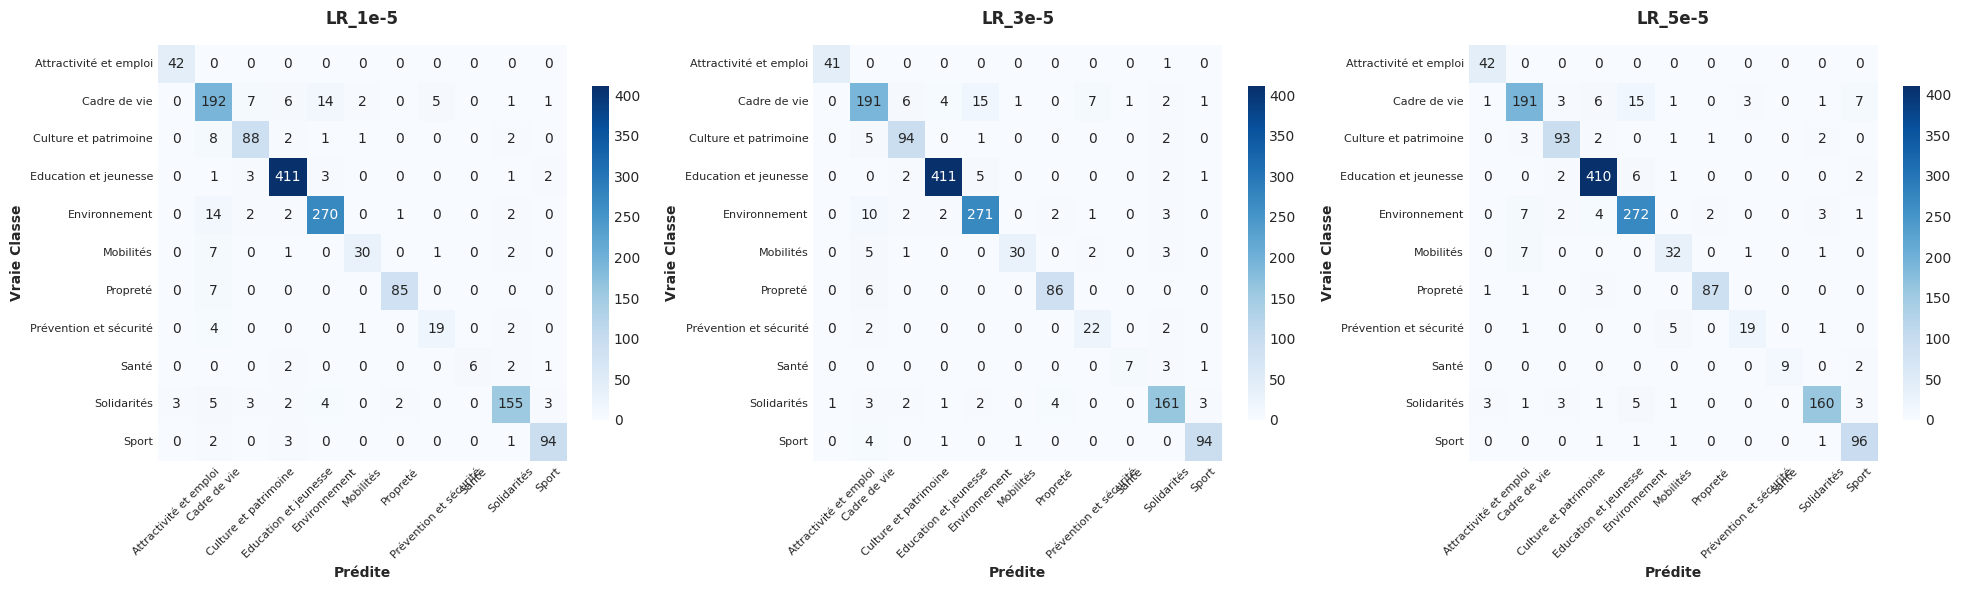

In [19]:
# Matrices de confusion pour les 3 modèles
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, lr_name in enumerate(lr_names):
    y_pred = predictions_dict[lr_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{lr_name}', fontsize=12, fontweight='bold', pad=15)
    axes[idx].set_ylabel('Vraie Classe', fontweight='bold')
    axes[idx].set_xlabel('Prédite', fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

## 6. Tests sur Nouveaux Titres avec le Meilleur Modèle

In [20]:
# Titres de test (en français pour correspondre au dataset)
test_titles = [
    "création d'un espace vert dans le quartier",
    "installation de panneaux solaires sur les bâtiments publics",
    "rénovation de la bibliothèque municipale",
    "organisation d'ateliers culturels pour les jeunes",
    "aménagement d'une piste cyclable sécurisée",
    "développement d'un jardin partagé communautaire"
]

print("\n" + "=" * 90)
print(" " * 15 + f" PRÉDICTIONS AVEC LE MEILLEUR MODÈLE: {best_model_name}")
print("=" * 90)

# Préparer les données pour CamemBERT
test_camembert = tokenize_data(pd.Series(test_titles))

# Prédire avec le meilleur modèle
best_model = models_dict[best_model_name]
predictions_proba = best_model.predict(
    [test_camembert['input_ids'], test_camembert['attention_mask']],
    verbose=0
)
predictions_classes = np.argmax(predictions_proba, axis=1)

for i, (title, class_idx, proba) in enumerate(zip(test_titles, predictions_classes, predictions_proba), 1):
    thematic = label_encoder.inverse_transform([class_idx])[0]
    confidence = proba[class_idx] * 100
    
    print(f"\n{i}. \"{title}\"")
    print(f"    Thématique prédite: {thematic}")
    print(f"    Confiance: {confidence:.1f}%")
    
    # Afficher les 3 prédictions les plus probables
    top3_indices = np.argsort(proba)[-3:][::-1]
    print(f"    Top 3 prédictions:")
    for idx in top3_indices:
        print(f"      - {label_encoder.inverse_transform([idx])[0]}: {proba[idx]*100:.1f}%")
    print("-" * 90)

print("\n" + "=" * 90)


                PRÉDICTIONS AVEC LE MEILLEUR MODÈLE: LR_5e-5

1. "création d'un espace vert dans le quartier"
    Thématique prédite: Environnement
    Confiance: 96.8%
    Top 3 prédictions:
      - Environnement: 96.8%
      - Prévention et sécurité: 0.8%
      - Education et jeunesse: 0.5%
------------------------------------------------------------------------------------------

2. "installation de panneaux solaires sur les bâtiments publics"
    Thématique prédite: Environnement
    Confiance: 96.7%
    Top 3 prédictions:
      - Environnement: 96.7%
      - Prévention et sécurité: 0.7%
      - Education et jeunesse: 0.5%
------------------------------------------------------------------------------------------

3. "rénovation de la bibliothèque municipale"
    Thématique prédite: Culture et patrimoine
    Confiance: 93.8%
    Top 3 prédictions:
      - Culture et patrimoine: 93.8%
      - Education et jeunesse: 1.9%
      - Cadre de vie: 0.9%
------------------------------------

## 7. Sauvegarde du Meilleur Modèle

Les cellules suivantes permettent de sauvegarder le meilleur modèle pour la production.
**Pour l'instant, ces cellules sont commentées - décommenter pour activer la sauvegarde.**

In [ ]:
# SAUVEGARDE DU MEILLEUR MODÈLE en h5 et sauvegarde du label mapping
import os
import pickle

print(f" Sauvegarde du meilleur modèle: {best_model_name}\n")
print("=" * 80)

# Créer le dossier de sauvegarde si nécessaire
save_dir = 'model/camembert/'
os.makedirs(save_dir, exist_ok=True)

# 1. Sauvegarder le modèle au format .keras (recommandé pour Keras 3 mais ici c'est h5 qui est utilisé par fastapi)
# model_keras_path = f'{save_dir}camembert-budgets-participatif.keras'
# best_model.save(model_keras_path)
# print(f" Modèle sauvegardé : {model_keras_path}")
# print(f"   Taille du fichier : {os.path.getsize(model_keras_path) / (1024**2):.1f} MB")

# 2. Sauvegarder uniquement les poids en .h5 (Pas obligé mais utile)
# weights_path = f'{save_dir}camembert-budgets-participatif_weights.h5'
# best_model.save_weights(weights_path)
# print(f" Poids sauvegardés (format .h5)    : {weights_path}")

# 3. Sauvegarder aussi au format h5 complet (utilisé par FastAPI dans ce projet)
model_h5_path = f'{save_dir}camembert-budgets-participatif.h5'
best_model.save(model_h5_path)
print(f"\n Modèle également sauvegardé en .h5 : {model_h5_path}")
print(f"   Taille du fichier : {os.path.getsize(model_h5_path) / (1024**2):.1f} MB")

# 4. Sauvegarder le tokenizer CamemBERT (pas nécessaire car on peut le recharger)
# Le tokenizer CamemBERT peut être rechargé avec:
# tokenizer_camembert = CamembertTokenizer.from_pretrained("camembert-base")

# 5. Sauvegarder le label mapping en JSON pour décoder les prédictions de int vers string
label_mapping_json_path = f'{save_dir}camembert_label_mapping.json'
mapping_dict = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
reverse_mapping = {str(label): int(i) for i, label in enumerate(label_encoder.classes_)}

with open(label_mapping_json_path, 'w', encoding='utf-8') as f:
    json.dump({
        'num_to_label': mapping_dict,
        'label_to_num': reverse_mapping,
        'num_classes': num_classes,
        'best_model': best_model_name,
        'best_learning_rate': float(best_lr),
        'best_test_accuracy': float(best_accuracy)
    }, f, ensure_ascii=False, indent=2)

print(f"\n Label mapping sauvegardé : {label_mapping_json_path}")

# 6. Sauvegarder le label encoder en pickle car il
# label_encoder_pickle_path = f'{save_dir}camembert_label_encoder.pickle'
# with open(label_encoder_pickle_path, 'wb') as handle:
#     pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print(f" Label encoder sauvegardé : {label_encoder_pickle_path}")

print("\n" + "=" * 80)
print(" Tous les fichiers ont été sauvegardés avec succès !")
print("=" * 80)

print("\n Fichiers sauvegardés:")
# print(f"   1. {model_keras_path}")
# print(f"   2. {weights_path} (RECOMMANDÉ pour rechargement)")
print(f"   3. {model_h5_path}")
print(f"   4. {label_mapping_json_path}")
# print(f"   5. {label_encoder_pickle_path}")


 Sauvegarde du meilleur modèle: LR_5e-5

 Modèle sauvegardé : model/camembert/camembert-budgets-participatif.keras
   Taille du fichier : 1267.1 MB
 Poids sauvegardés (format .h5)    : model/camembert/camembert-budgets-participatif_weights.h5

 Modèle également sauvegardé en .h5 : model/camembert/camembert-budgets-participatif.h5
   Taille du fichier : 1267.3 MB

 Label mapping sauvegardé : model/camembert/camembert_label_mapping.json
 Label encoder sauvegardé : model/camembert/camembert_label_encoder.pickle

 Tous les fichiers ont été sauvegardés avec succès !

 Fichiers sauvegardés:
   1. model/camembert/camembert-budgets-participatif.keras
   2. model/camembert/camembert-budgets-participatif_weights.h5 (RECOMMANDÉ pour rechargement)
   3. model/camembert/camembert-budgets-participatif.h5
   4. model/camembert/camembert_label_mapping.json
   5. model/camembert/camembert_label_encoder.pickle

 Pour le rechargement, il est RECOMMANDÉ d'utiliser les poids uniquement
   et de reconstruir